In [6]:
import numpy as np
import tsplib95 as tsp

In [2]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm

In [3]:
from tsp_problem import TSP_Problem

In [4]:
from population import Population

In [5]:
from ga import GA

## Problem (Djibouti)
**(optimal tour for the dj38 TSP has length 6656)**. From http://www.math.uwaterloo.ca/tsp/world/djtour.html

Best solution found so far: 6660 distance-unit

**[25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,  5,
       3,  4,  2,  1, 10, 14, 21, 29, 30, 32, 35, 37, 38, 33, 34, 36, 31,
       27, 28, 24, 22, 25]**

with:
* population_size = 300
* nb_generation = 200
* elite=0
* "crossover_proba": 0.9, "sequence_max_width": 10
* "mutation_proba": 0.1, "sequence_max_width": 5

### Loading problem

In [1]:
djibouti = tsp.load("./data/dj38.tsp")

NameError: name 'tsp' is not defined

### Get x,y coordinates for all cities

In [7]:
djibouti_cities = np.array([djibouti.node_coords[city] for city in list(djibouti.get_nodes())])
djibouti_cities[:2]

array([[11003.6111, 42102.5   ],
       [11108.6111, 42373.8889]])

### Create our problem

In [8]:
djibouti_pb = TSP_Problem("dj38", djibouti_cities)

### Create a population to resolve this problem

In [84]:
solutions = Population(djibouti_pb, 400)

### Run GA

In [85]:
algo = GA(solutions, nb_generation=100, elite_ratio=0.05,
          selection_op="tournament", selection_params={"K": 2},
          crossover_op="ordered", crossover_params={"crossover_proba": 0.9, "sequence_max_width": 10},
          mutation_op="scramble", mutation_params={"mutation_proba": 0.1, "sequence_max_width": 5})

In [100]:
%%time
algo.run()

Wall time: 46.9 s


In [113]:
solutions.best_fitness

7762.0

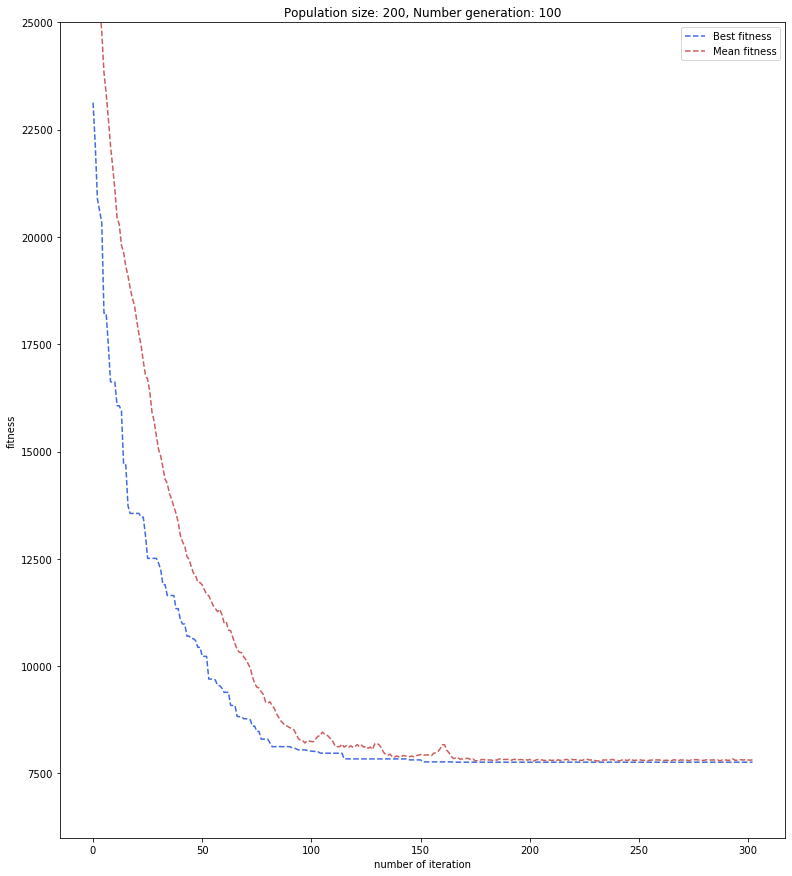

In [114]:
plot_problems(solutions.logs, 200, 100, [6000, 25000])

### Plot

In [14]:
def plot_problems(logs, popsize, nb_gen, ylim=[-450, 2500]):
    fig, ax = plt.subplots(figsize=(13,15))
    plt.axes(ax)
    #plt.yscale('log')
    #plt.xscale('log')
    color=iter(cm.rainbow(np.linspace(0,1,len(logs))))
    # plot best
    col=next(color)
    x = [log[0] for log in logs]
    y_best = [log[1] for log in logs]
    y_mean = [log[3] for log in logs]
    plt.plot(x[:], y_best[:], "k--", color="royalblue", label="Best fitness")
    col=next(color)
    plt.plot(x[:], y_mean[:], "k--", color="indianred", label="Mean fitness")
    ax.set_ylim(ylim)
    ax.set_title("Population size: {0}, Number generation: {1}".format(popsize, nb_gen))
    ax.set_xlabel("number of iteration")
    ax.set_ylabel("fitness")
    ax.legend()
    return

___

# Classes to test

In [ ]:
class Selection_Tournament:
    '''
    Tournament selection operator:
    1. Random uniform select of K individuals
    2. Select the fittest of these K individuals
    3. Repeat 1., 2. until the reach the desired number of individuals
    '''
    def __init__(self, selection_params):
        '''
        Parameters
        ----------
        selection_parameters includes:
        - selective pressure K, used to select number of individual
            per tournament. The higher K, the more probability the best
            individuals will be selected (-> loss of diversity).
            A recommended value is 2.
        '''
        self.K = selection_params["K"]

    def select(self, population):
        '''
        Parameters
        ----------
        - The current population instance
        Return
        ------
        - a numpy array, selection of individuals to serve for reproduction
            (crossover)
        '''
        #selection_size = int(round(self.p_ratio*population.size))
        selection_idxs = []
        for _ in range(population.size):
            # Select K individuals by index
            idxs = np.random.choice(range(population.size),
                                    size=self.K,
                                    replace=False)
            print("--- idxs ->",idxs)

            # Get the best individual (best fitness) by argsort-ing the 
            # fitness vector (population.fitness)
            # we are expecting minimisation problem, best fitness is index 0
            best_idx = idxs[np.argsort(population.fitness[idxs])[0]]
            selection_idxs.append(best_idx)
            print("    best_idx -> {0}".format(best_idx))

        # Return the selected individuals
        return(population.individuals[np.array(selection_idxs)])

In [ ]:
class Crossover_Ordered:
    '''
    Ordered crossover operator:
    Loop for nb_offsprings to be generated
    1. Select (uniform random) two parents from the entire population
    2. Roll a (uniform!) dice ! If probability is < than
        crossover_proba then perform crossover.
        Else the two parents are kept as if for the next generation.
    3. Select (uniform random) two crossover points
    4. Copy genes within crossover points from parent1 to child2
        and parent2 to child1
    5. Complete child1 sequence with parent1, child2 with parent2
    '''
    def __init__(self, crossover_params):
        '''
        - crossover_params: The crossover paramaters. Expected is
            only the crossover probability
        '''
        self.crossover_proba = crossover_params["crossover_proba"]
        self.max_width = crossover_params["sequence_max_width"]

    def crossover(self, parents, nb_offsprings):
        '''
        Perform the crossover
        Parameters
        ----------
        - all parents that have been selected for crossover
            as numpy ndarray
        - the number of offsprings to generate. That depends on the
            ratio of elite individuals that will be kept for next
            generation.
        Return
        ------
        - the offsprings as a numpy ndarray
        '''
        rng = np.random.default_rng()
        parents_size = parents.shape[0]
        dim = parents.shape[1]
        current_nb_offsprings = 0
        while current_nb_offsprings < nb_offsprings:
            # randomly (uniform) select two parents
            # by selecting two indexes from the
            # parents array (with no repetition)
            parents_idx = rng.choice(parents_size, size=2, replace=False)
            parent1 = parents[parents_idx][0]
            parent2 = parents[parents_idx][1]
            
            print("------")
            print("parent1: {0}".format(parent1))
            print("parent2: {0}".format(parent2))

            # Probability of performing crossover
            # if < self.crossover_proba perform cross over
            # for these 2 parents
            if rng.uniform() < self.crossover_proba:
                
                print("** Crossover")

                # randomly (uniform) select two crossover points
                # distant within [2, self.max_witdh]
                invalid_sequence = True
                while invalid_sequence:
                    seq = np.sort(rng.choice(dim, size=2, replace=False))
                    if ((seq[1] - seq[0]) <= self.max_width) and\
                       ((seq[1] - seq[0]) > 1):
                        invalid_sequence = False
                
                print("crossover_points: {0}".format(seq))

                # initialise a child1, child2 array
                child1 = -1*np.ones(dim, dtype=np.int32)
                child2 = -1*np.ones(dim, dtype=np.int32)

                # copy the genes between crossover points
                # from parents1 to child2 and parents2 to child1
                #child1[crossover_points[0]:crossover_points[1]] = parent2[crossover_points[0]:crossover_points[1]]
                #child2[crossover_points[0]:crossover_points[1]] = parent1[crossover_points[0]:crossover_points[1]]
                #child1[crossover_range] = np.copy(parent2[crossover_range])
                #child2[crossover_range] = np.copy(parent1[crossover_range])
                child1[seq[0]:seq[1]] = parent2[seq[0]:seq[1]]
                child2[seq[0]:seq[1]] = parent1[seq[0]:seq[1]]
                
                print("child1: {0}".format(child1))
                print("child2: {0}".format(child2))

                # complete the child1 with parent1 and child2 with
                # parent2
                child1 = self.complete_sequence(child1, parent1, seq, dim)
                child2 = self.complete_sequence(child2, parent2, seq, dim)
                print("child1: {0}".format(child1))
                print("child2: {0}".format(child2))
            # else, we keep parents as-is for next generation
            else:
                print("** NO Crossover")
                child1 = np.copy(parent1)
                child2 = np.copy(parent2)

            # adding children to the array of offsprings
            if current_nb_offsprings == 0:
                offsprings = child1
                offsprings = np.concatenate((offsprings, child2), axis=0)
                current_nb_offsprings = current_nb_offsprings + 2
            elif current_nb_offsprings <= (nb_offsprings - 2):
                offsprings = np.concatenate((offsprings, child1), axis=0)
                offsprings = np.concatenate((offsprings, child2), axis=0)
                current_nb_offsprings = current_nb_offsprings + 2
            else:
                offsprings = np.concatenate((offsprings, child1), axis=0)
                current_nb_offsprings = current_nb_offsprings + 1

        # reshape offsprings to a (self.nb_offsprings, dimension)
        # array
        offsprings = offsprings.reshape(-1, dim)

        return(offsprings)

    def complete_sequence(self, child, parent, cx_point, d):
        idx_child = idx_parent = cx_point[1]
        not_complete = True
        #print("#### complete_sequence")
        #print("child: {0}".format(child))
        #print("parent: {0}".format(parent))
        #print("cx_point[1] {0}".format(cx_point[1]))
        # complete upper range of the sequence first
        while not_complete:
            # for idx in range(cx_point[1], dim):
            #print("idx_child: {0}, idx_parent: {1}".format(idx_child, idx_parent))
            if parent[idx_parent] not in child:
                child[idx_child] = parent[idx_parent]
                if idx_child == (d-1):
                    idx_child = 0
                else:
                    idx_child = idx_child + 1
            if idx_parent == (d-1):
                idx_parent = 0
            else:
                idx_parent = idx_parent + 1
            # testing if sequence is complete
            # i.e. idx_child = cx_point[0]
            if idx_child == cx_point[0]:
                not_complete = False
        #print("#### DONE complete_sequence")
        return(child)

In [ ]:
class Mutation_Scramble:
    '''
    The Scramble (or Shuffle) Mutation operator: A sequence of genes
    is randomly selected and shuffled
    '''
    def __init__(self, mutation_params):
        '''
        Parameters:
        -----------
        - the mutation probability
        - the width of the sequence of genes on which to apply
            shuffling
        '''
        self.mutation_proba = mutation_params["mutation_proba"]
        self.max_width = mutation_params["sequence_max_width"]

    def mutate(self, offsprings):
        '''
        Perform the scramble mutation for all offsprings
        1. roll a (uniform!) dice ! If probability is < than
            mutation_proba then perform mutation.
        2. Select (random uniform) a sequence of genes to scramble
        3. shuffle them
        Parameters
        ----------
        - The offsprings (as a numpy array) on which to apply
            the mutation
        Return
        ------
        - the modified offsprings (althought not necessary as mutation
            is done inplace)
        '''
        rng = np.random.default_rng()
        nb_offsprings = offsprings.shape[0]
        dim = offsprings.shape[1]

        for i in range(nb_offsprings):
            # !!!
            # Similarly to the Mutation Inversion operator,
            # by ordering the random choice of index, we somehow
            # prevent shuffling happening on the array bounds,
            # i.e. shuffling on say indexes 8.9.0.1 -> 9.1.0.8
            # will never happen.
            # The effect on the quality of this operator is unknown.
            # In theory, it will be better to also allow these
            # types of shuffling, i.e. considering the array as a
            # circular array

            # Probability of performing mutation
            # if < self.mutation_proba perform mutation
            # else NO mutation for this offspring
            print("--- {0}".format(i))
            if rng.uniform() < self.mutation_proba:
                print("** Mutate")
                # Find a sequence of gene to shuffle
                invalid_sequence = True
                while invalid_sequence:
                    seq = np.sort(rng.choice(dim, size=2, replace=False))
                    if ((seq[1] - seq[0]) <= self.max_width) and\
                       ((seq[1] - seq[0]) > 1):
                        invalid_sequence = False
                    print("sequence: {0}".format(seq))

                # Shuffle the sequence inplace
                print("offspring before {0}".format(offsprings[i]))
                rng.shuffle(offsprings[i][seq[0]:seq[1]])
                print("offspring after  {0}".format(offsprings[i]))

        return(offsprings)

In [ ]:
class Mutation_Swap:
    '''
    The Swap Mutation operator: Two genes are randomly selected
    and swapped together.
    '''
    def __init__(self, mutation_params):
        '''
        Parameters:
        -----------
        - the mutation probability
        '''
        self.mutation_proba = mutation_params["mutation_proba"]

    def mutate(self, offsprings):
        '''
        Perform the swap mutation for all offsprings
        1. roll a (uniform!) dice ! If probability is < than
            mutation_proba then perform mutation.
        2. select (random uniform) two genes (indices)
        3. swap them
        Parameters
        ----------
        - the offsprings (as a numpy array) on which to apply
            the mutation
        Return
        ------
        - the modified offsprings (althought not necessary as mutation
            is done inplace)
        '''
        rng = np.random.default_rng()
        nb_offsprings = offsprings.shape[0]
        dim = offsprings.shape[1]

        for i in range(nb_offsprings):
            print("--- {0}".format(i))
            # Probability of performing mutation
            # if < self.mutation_proba perform mutation
            # else NO mutation for this offspring
            if rng.uniform() < self.mutation_proba:
                print("Mutate!")
                idxs = rng.choice(dim, size=2, replace=False)
                print("idxs: {0}".format(idxs))
                print("before {0}".format(offsprings[i]))
                temp = offsprings[i][idxs[0]]
                offsprings[i][idxs[0]] = offsprings[i][idxs[1]]
                offsprings[i][idxs[1]] = temp
                print("after {0}".format(offsprings[i]))
                

        return(offsprings)

In [ ]:
class Mutation_Inversion:
    '''
    The Inversion Mutation operator: A sequence of genes is
    randomly selected and inversed
    '''
    def __init__(self, mutation_params):
        '''
        Parameters:
        -----------
        - the mutation probability
        - the width of the sequence of genes on which to apply
        inversion
        '''
        self.mutation_proba = mutation_params["mutation_proba"]
        self.max_width = mutation_params["sequence_max_width"]

    def mutate(self, offsprings):
        '''
        Perform the inversion mutation for all offsprings
        1. roll a (uniform!) dice ! If probability is < than
            mutation_proba then perform mutation.
        2. Select (random uniform) a sequence of genes to inverse
        3. Inverse them
        Parameters
        ----------
        - The offsprings (as a numpy array) on which to apply
            the mutation
        Return
        ------
        - the modified offsprings (althought not necessary as mutation
            is done inplace)
        '''
        rng = np.random.default_rng()
        nb_offsprings = offsprings.shape[0]
        dim = offsprings.shape[1]

        for i in range(nb_offsprings):
            print("--- {0}".format(i))
            # !!!
            # By ordering the random choice of index, we somehow
            # prevent inversion happening on the array bounds,
            # i.e. inversion on say indexes 8.9.0.1 -> 1.0.9.8
            # will never happen.
            # The effect on the quality of this operator is unknown.
            # In theory, it will be better to also allow these
            # types of inversion, i.e. considering the array as a
            # circular array

            # Probability of performing mutation
            # if < self.mutation_proba perform mutation
            # else NO mutation for this offspring
            if rng.uniform() < self.mutation_proba:
                # Find a sequence of gene to inverse
                invalid_sequence = True
                while invalid_sequence:
                    seq = np.sort(rng.choice(dim, size=2, replace=False))
                    if ((seq[1] - seq[0]) <= self.max_width) and\
                       ((seq[1] - seq[0]) > 1):
                        invalid_sequence = False
                print("seq: {0}".format(seq))

                # Inverse the sequence inplace
                print("before: {0}".format(offsprings[i]))
                offsprings[i][seq[0]:seq[1]] = \
                    offsprings[i][seq[0]:seq[1]][::-1]
                print("after: {0}".format(offsprings[i]))

        return(offsprings)

## Tests

In [92]:
offspring = np.array([25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,  5,
       3,  4,  2,  1, 10, 14, 21, 29, 30, 32, 35, 37, 38, 33, 34, 36, 31,
       27, 28, 24, 22])

In [93]:
dim = 38

In [67]:
rng = np.random.default_rng()

In [94]:
seq = np.array([27, 14], dtype=np.int64)
seq

array([27, 14], dtype=int64)

___

In [2]:
abs(-3)

3

In [ ]:
a = seq[0]
b = seq[1]

In [ ]:
seq1 = offspring[a:]
seq2 = offspring[0:b]

In [ ]:
to_reverse = np.concatenate((seq1,seq2))

In [ ]:
seq1_l = seq1.shape[0]

In [ ]:
offspring[a:] = to_reverse[::-1][:seq1_l]

In [ ]:
offspring[:b] = to_reverse[::-1][seq1_l:]

___

In [95]:
a = seq[0]
b = seq[1]

In [96]:
seq1 = offspring[a:]
seq2 = offspring[0:b]
seq1, seq2

(array([35, 37, 38, 33, 34, 36, 31, 27, 28, 24, 22]),
 array([25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8]))

In [97]:
to_reverse = np.concatenate((seq1,seq2))

array([35, 37, 38, 33, 34, 36, 31, 27, 28, 24, 22, 25, 26, 23, 20, 15, 13,
       19, 18, 17, 16, 12, 11,  9,  8])

In [101]:
to_reverse[::-1]

array([ 8,  9, 11, 12, 16, 17, 18, 19, 13, 15, 20, 23, 26, 25, 22, 24, 28,
       27, 31, 36, 34, 33, 38, 37, 35])

In [104]:
seq1_l = seq1.shape[0]

In [105]:
seq1_l

11

In [109]:
seq2_l = seq2.shape[0]
seq2_l

14

In [106]:
to_reverse[::-1][:seq1_l]

array([ 8,  9, 11, 12, 16, 17, 18, 19, 13, 15, 20])

In [107]:
offspring[a:] = to_reverse[::-1][:seq1_l]

In [108]:
offspring

array([25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,  5,
        3,  4,  2,  1, 10, 14, 21, 29, 30, 32,  8,  9, 11, 12, 16, 17, 18,
       19, 13, 15, 20])

In [110]:
offspring[:b] = to_reverse[::-1][seq1_l:]

In [111]:
offspring

array([23, 26, 25, 22, 24, 28, 27, 31, 36, 34, 33, 38, 37, 35,  7,  6,  5,
        3,  4,  2,  1, 10, 14, 21, 29, 30, 32,  8,  9, 11, 12, 16, 17, 18,
       19, 13, 15, 20])

In [ ]:
[25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,  5,
       3,  4,  2,  1, 10, 14, 21, 29, 30, 32, 35, 37, 38, 33, 34, 36, 31,
       27, 28, 24, 22]

In [112]:
to_reverse[::-1]

array([ 8,  9, 11, 12, 16, 17, 18, 19, 13, 15, 20, 23, 26, 25, 22, 24, 28,
       27, 31, 36, 34, 33, 38, 37, 35])

In [ ]:
sol = [25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,  5,
       3,  4,  2,  1, 10, 14, 21, 29, 30, 32, 35, 37, 38, 33, 34, 36, 31,
       27, 28, 24, 22, 25]

In [ ]:
distance = 0
for city1, city2 in zip(sol, sol[1:]):
    d = djibouti.get_weight(city1, city2)
    print("{0} -> {1}: {2}".format(city1, city2, d))
    distance = distance + d
print(distance)

In [ ]:
djibouti.get_weight(31,36)

In [ ]:
round(299*0.05)

In [16]:
sol = np.array([25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,  5,
       3,  4,  2,  1, 10, 14, 21, 29, 30, 32, 35, 37, 38, 33, 34, 36, 31,
       27, 28, 24, 22])

In [22]:
dim=38
sol = np.concatenate((sol,sol), axis = 0)
sol = sol.reshape(-1,dim)

In [23]:
sol.shape

(4, 38)

In [24]:
mutation_proba = 1
max_width = 10

In [31]:
los = mutate_x(sol)

g1: 17, g2 23
g1: 8, g2 2
** g1 > g2
seq to reverse [17 16 12 11  9  2  4  3  5  6  7  8  1 10 14 21 29 38 37 35 33 30 32 34
 36 31 27 28 24 22 25 26]
reversed       [26 25 22 24 28 27 31 36 34 32 30 33 35 37 38 29 21 14 10  1  8  7  6  5
  3  4  2  9 11 12 16 17]
g1: 15, g2 5
** g1 > g2
seq to reverse [ 6  5  3  4 29 30 14 10  1  2 21 32 35 33 38 37 34 36 31 27 28 24 22 25
 26 23 20 15]
reversed       [15 20 23 26 25 22 24 28 27 31 36 34 37 38 33 35 32 21  2  1 10 14 30 29
  4  3  5  6]
g1: 19, g2 12
** g1 > g2
seq to reverse [ 2  1 10 14 21 29 30 31 36 34 33 38 37 35 32 24 28 27 22 25 26 23 20 15
 13 19 18 17 16  8  9]
reversed       [ 9  8 16 17 18 19 13 15 20 23 26 25 22 27 28 24 32 35 37 38 33 34 36 31
 30 29 21 14 10  1  2]


In [26]:
los

array([[25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,
         5,  3, 32, 30, 29, 21, 14, 10,  1,  2,  4, 35, 37, 38, 33, 34,
        36, 31, 27, 28, 24, 22],
       [25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,
         5,  3,  4,  2,  1, 10, 14, 21, 29, 38, 37, 35, 32, 30, 33, 34,
        36, 31, 27, 28, 24, 22],
       [25, 26, 23, 20, 15, 13, 19, 18, 17, 16, 12, 11,  9,  8,  7,  6,
         5,  3,  4,  2,  1, 10, 14, 21, 29, 30, 32, 35, 33, 38, 37, 34,
        36, 31, 27, 28, 24, 22],
       [25, 26, 23, 20, 15, 13, 19, 18, 17, 16,  8,  9, 11, 12,  7,  6,
         5,  3,  4,  2,  1, 10, 14, 21, 29, 30, 32, 35, 37, 38, 33, 34,
        36, 31, 27, 28, 24, 22]])

In [30]:
def mutate_x(offsprings):
    rng = np.random.default_rng()
    nb_offsprings = offsprings.shape[0]
    dim = offsprings.shape[1]

    for i in range(nb_offsprings):
        # Probability of performing mutation
        # if < self.mutation_proba perform mutation
        # else NO mutation for this offspring
        if rng.uniform() < mutation_proba:
            # Find a sequence of gene to inverse
            invalid_sequence = True
            while invalid_sequence:
                seq = rng.choice(dim, size=2, replace=False)
                g1 = seq[0]
                g2 = seq[1]
                if (abs(g1 - g2) <= max_width) and\
                    (abs(g1 - g2) > 1):
                    invalid_sequence = False
            print("g1: {0}, g2 {1}".format(g1,g2))
            # if gene1 position is > gene2 position, we need
            # to build the sequence to inverse first, that is
            # offspring[g1:] + oggspring[:g2]
            # then inverse it and insert/replace in offspring
            # at the correct position
            if g1 > g2:
                print("** g1 > g2")
                # Build the reverse sequence
                seq1 = offsprings[i][g1:]
                seq2 = offsprings[i][:g2]
                seq_to_reverse = np.concatenate((seq1, seq2))
                seq1_size = seq1.shape[0]
                
                print("seq to reverse {0}".format(seq_to_reverse))
                print("reversed       {0}".format(seq_to_reverse[::-1]))

                # insert at the correct position
                offsprings[i][g1:] = seq_to_reverse[::-1][:seq1_size]
                offsprings[i][:g2] = seq_to_reverse[::-1][seq1_size:]

            else:
                # Inverse the sequence inplace
                offsprings[i][g1:g2] = offsprings[i][g1:g2][::-1]

    return(offsprings)